<a href="https://colab.research.google.com/github/M0hammad-Kashif/SketchToFace/blob/main/sketch_to_face.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Downloading

In [1]:
!echo '{"username":"mohammadkashif20","key":"029e913c85378ab69c8d83b71b3f3bcc"}' >> kaggle.json

! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d yewtsing/pretty-face


import zipfile
with zipfile.ZipFile("/content/pretty-face.zip","r") as zip_ref:
    zip_ref.extractall("Dataset")



!cp -R '/content/Dataset/face/face' ~+
!cp -R '/content/Dataset/layout/layout' ~+
!cp -R '/content/Dataset/sketch/sketch' ~+

!rm -rf '/content/Dataset'
!rm -rf '/content/sample_data'
!rm  '/content/pretty-face.zip'
!rm '/content/kaggle.json'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
 98% 1.17G/1.19G [00:06<00:00, 208MB/s]
100% 1.19G/1.19G [00:06<00:00, 183MB/s]


In [2]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 4.0 MB/s 
     |████████████████████████████████| 181 kB 58.4 MB/s 
     |████████████████████████████████| 157 kB 64.6 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 
     |████████████████████████████████| 157 kB 72.0 MB/s 
     |████████████████████████████████| 157 kB 74.2 MB/s 
     |████████████████████████████████| 157 kB 78.2 MB/s 
     |████████████████████████████████| 156 kB 74.7 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=58843b87f4dda5ea2a02578018dd874bd43b0c4733c0a11e31359cc209ab1848
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


# Imports

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import randint
from PIL import Image
import torch.optim as optim
import torch.nn as nn
import torch
from tqdm import tqdm
import wandb
import time
import gc
from torchvision.utils import make_grid

# Configurations

In [4]:
class CFG:
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    LR = 1e-3
    BATCH_SIZE = 128
    IMG_CHANNEL = 3
    L1_LAMBDA = 100
    LAMBDA_GP = 10
    EPOCHS = 500
    IMG_SIZE = 256

# Dataloader and Transformations

In [5]:
face_path = '/content/face'
sketch_path = '/content/sketch'

face_file = os.listdir(face_path)
sketch_file = os.listdir(sketch_path)
print(len(face_file))
print(len(sketch_file))

3318
3318


(512, 512, 3)
(512, 512, 3)


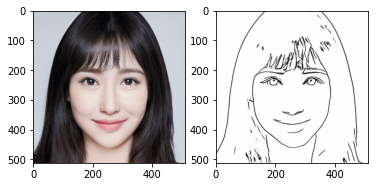

In [6]:
ix = randint(0,len(face_file))
file_name = face_file[ix]
face_img = Image.open(os.path.join(face_path, file_name))
face_img = np.array(face_img)
print(face_img.shape)
img_no = file_name.split('.')[0]
sketch_img = Image.open(os.path.join(sketch_path, img_no+'_edges.jpg'))
sketch_img = np.array(sketch_img)
print(sketch_img.shape)
plt.subplot(1,2,1)
plt.imshow(face_img)
plt.subplot(1,2,2)
plt.imshow(sketch_img)

In [7]:
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset, dataloader
from torch.utils.data import DataLoader

In [8]:
IMAGE_SIZE = 256
IMG_CHANNELS = 3
BATCH_SIZE = 64

In [9]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

transforms = A.Compose(
    [   
        A.Resize(CFG.IMG_SIZE, CFG.IMG_SIZE),
        A.Normalize(
         [0.5 for _ in range(CFG.IMG_CHANNEL)], [0.5 for _ in range(CFG.IMG_CHANNEL)]
        ),
        ToTensorV2(),
    ]
)

In [10]:
def img_arr(path, file):
  img = Image.open(os.path.join(path, file))
  img = np.array(img)

  return img

In [11]:
class CustomImageDataset(Dataset):
  def __init__(self, face_dir, sketch_dir, transform=None):
    self.face_dir = face_dir
    self.sketch_dir = sketch_dir
    self.face_files = os.listdir(self.face_dir)
    self.sketch_files = os.listdir(self.sketch_dir)
    self.transform = transform

  def __len__(self):
     return len(self.face_files)

  def __getitem__(self, idx):
    face_file = self.face_files[idx]
    face_img = img_arr(self.face_dir, face_file)
    img_no = face_file.split('.')[0]
    sketch_img = img_arr(self.sketch_dir, img_no+'_edges.jpg')

    if self.transform:
      face_img = self.transform(image=face_img)['image']
      sketch_img = self.transform(image=sketch_img)['image']

    return sketch_img, face_img  



In [12]:
dataset = CustomImageDataset(face_path, sketch_path,transforms)
dataloader = DataLoader(dataset, batch_size = CFG.BATCH_SIZE)

torch.Size([128, 3, 256, 256])
torch.Size([128, 3, 256, 256])


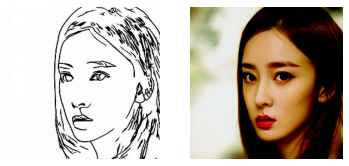

In [13]:
for idx , (sketch_img, face_img ) in enumerate(dataloader):
  print(sketch_img.shape)
  print(face_img.shape)
  plt.subplot(1,2,1)
  plt.imshow(sketch_img[4].permute(1,2,0))
  plt.axis("off")
  plt.subplot(1,2,2)
  plt.imshow(face_img[4].permute(1,2,0))
  plt.axis("off")
  break

# Generator

In [14]:
import torch
import torch.nn as nn


class Block(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, act="relu", use_dropout=False):
        super(Block, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 4, 2, 1, bias=False, padding_mode="reflect")
            if down
            else nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU() if act == "relu" else nn.LeakyReLU(0.2),
        )

        self.use_dropout = use_dropout
        self.dropout = nn.Dropout(0.5)
        self.down = down

    def forward(self, x):
        x = self.conv(x)
        return self.dropout(x) if self.use_dropout else x


class Generator(nn.Module):
    def __init__(self, in_channels=3, features=64):
        super().__init__()
        self.initial_down = nn.Sequential(
            nn.Conv2d(in_channels, features, 4, 2, 1, padding_mode="reflect"),
            nn.LeakyReLU(0.2),
        )
        self.down1 = Block(features, features * 2, down=True, act="leaky", use_dropout=False)
        self.down2 = Block(
            features * 2, features * 4, down=True, act="leaky", use_dropout=False
        )
        self.down3 = Block(
            features * 4, features * 8, down=True, act="leaky", use_dropout=False
        )
        self.down4 = Block(
            features * 8, features * 8, down=True, act="leaky", use_dropout=False
        )
        self.down5 = Block(
            features * 8, features * 8, down=True, act="leaky", use_dropout=False
        )
        self.down6 = Block(
            features * 8, features * 8, down=True, act="leaky", use_dropout=False
        )
        self.bottleneck = nn.Sequential(
            nn.Conv2d(features * 8, features * 8, 4, 2, 1), nn.ReLU()
        )

        self.up1 = Block(features * 8, features * 8, down=False, act="relu", use_dropout=True)
        self.up2 = Block(
            features * 8 * 2, features * 8, down=False, act="relu", use_dropout=True
        )
        self.up3 = Block(
            features * 8 * 2, features * 8, down=False, act="relu", use_dropout=True
        )
        self.up4 = Block(
            features * 8 * 2, features * 8, down=False, act="relu", use_dropout=False
        )
        self.up5 = Block(
            features * 8 * 2, features * 4, down=False, act="relu", use_dropout=False
        )
        self.up6 = Block(
            features * 4 * 2, features * 2, down=False, act="relu", use_dropout=False
        )
        self.up7 = Block(features * 2 * 2, features, down=False, act="relu", use_dropout=False)
        self.final_up = nn.Sequential(
            nn.ConvTranspose2d(features * 2, in_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        d1 = self.initial_down(x)
        d2 = self.down1(d1)
        d3 = self.down2(d2)
        d4 = self.down3(d3)
        d5 = self.down4(d4)
        d6 = self.down5(d5)
        d7 = self.down6(d6)
        bottleneck = self.bottleneck(d7)
        up1 = self.up1(bottleneck)
        up2 = self.up2(torch.cat([up1, d7], 1))
        up3 = self.up3(torch.cat([up2, d6], 1))
        up4 = self.up4(torch.cat([up3, d5], 1))
        up5 = self.up5(torch.cat([up4, d4], 1))
        up6 = self.up6(torch.cat([up5, d3], 1))
        up7 = self.up7(torch.cat([up6, d2], 1))
        return self.final_up(torch.cat([up7, d1], 1))



# Discriminator

In [15]:
import torch
import torch.nn as nn


class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super(CNNBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels, out_channels, 4, stride, 1, bias=False, padding_mode="reflect"
            ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.conv(x)


class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=[64, 128, 256, 512]):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(
                in_channels * 2,
                features[0],
                kernel_size=4,
                stride=2,
                padding=1,
                padding_mode="reflect",
            ),
            nn.LeakyReLU(0.2),
        )

        layers = []
        in_channels = features[0]
        for feature in features[1:]:
            layers.append(
                CNNBlock(in_channels, feature, stride=1 if feature == features[-1] else 2),
            )
            in_channels = feature

        layers.append(
            nn.Conv2d(
                in_channels, 1, kernel_size=4, stride=1, padding=1, padding_mode="reflect"
            ),
        )

        self.model = nn.Sequential(*layers)

    def forward(self, x, y):
        x = torch.cat([x, y], dim=1)
        x = self.initial(x)
        x = self.model(x)
        return x


# Loss and Optimizers

In [16]:
disc = Discriminator(in_channels=CFG.IMG_CHANNEL).to(CFG.DEVICE).to(CFG.DEVICE)
gen = Generator(in_channels=CFG.IMG_CHANNEL, features=64).to(CFG.DEVICE).to(CFG.DEVICE)

opt_disc = optim.Adam(disc.parameters(), lr=CFG.LR, betas=(0.5, 0.999))
opt_gen = optim.Adam(gen.parameters(), lr=CFG.LR, betas=(0.5, 0.999))


BCE = nn.BCEWithLogitsLoss()
L1_LOSS = nn.L1Loss()

# Training part

In [17]:
def train_one_epoch(gen,disc,loader, opt_disc, opt_gen, l1_loss, bce, g_scaler, d_scaler):

  pBar = tqdm(enumerate(loader),total=len(loader))

  for idx, (sketch, image) in pBar:

    sketch = sketch.to(CFG.DEVICE)
    image = image.to(CFG.DEVICE)  

    # training Discriminator
    with torch.cuda.amp.autocast():
      image_fake = gen(sketch)

      D_real = disc(sketch,image)
      D_real_loss = BCE(D_real,torch.ones_like(D_real))

      D_fake = disc(sketch , image_fake.detach())
      D_fake_loss = BCE(D_fake,torch.zeros_like(D_fake))

      D_loss = D_fake_loss + D_real_loss

    disc.zero_grad()
    d_scaler.scale(D_loss).backward()
    d_scaler.step(opt_disc)
    d_scaler.update()

    # Training Generator
    with torch.cuda.amp.autocast():
      D_fake = disc(sketch,image_fake)
      G_fake_loss = BCE(D_fake,torch.ones_like(D_fake))
      L1 = L1_LOSS(image_fake,image)*CFG.L1_LAMBDA
      G_loss = G_fake_loss + L1

    opt_gen.zero_grad()
    g_scaler.scale(G_loss).backward()
    g_scaler.step(opt_gen)
    g_scaler.update()

    if idx % 10 == 0:      
      grid1 = make_grid(sketch[:4])
      grid2 = make_grid(image_fake[:4])
      
      grid1 = wandb.Image(grid1, caption="Sketch")
      grid2 = wandb.Image(grid2, caption="Produced Image")
      
      wandb.log({"Sketch": grid1})
      wandb.log({"Produced Image": grid2})
      
  
    mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
    pBar.set_postfix(G_loss=f'{G_loss.item():0.4f}',
                       D_loss=f'{D_loss.item():0.4f}',
                      gpu_mem=f'{mem:0.2f} GB')
    torch.cuda.empty_cache()
    gc.collect()









In [18]:
def train(CFG=CFG,loader=dataloader):

  wandb.init("Sketch2Face")
  g_scaler = torch.cuda.amp.GradScaler()
  d_scaler = torch.cuda.amp.GradScaler()

  if torch.cuda.is_available():
    print("cuda: {}\n".format(torch.cuda.get_device_name()))

  start = time.time()

  for epoch in range(CFG.EPOCHS):

    print(f"Epoch {epoch + 1}")

    train_one_epoch(gen,disc,dataloader,opt_disc,opt_gen,L1_LOSS,BCE,g_scaler,d_scaler)
    print("-"*100)
    print("\n")






In [19]:
train()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


cuda: Tesla P100-PCIE-16GB

Epoch 1


100%|██████████| 26/26 [02:09<00:00,  4.99s/it, D_loss=1.3660, G_loss=40.2653, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 2


100%|██████████| 26/26 [02:02<00:00,  4.70s/it, D_loss=1.4343, G_loss=33.2661, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 3


100%|██████████| 26/26 [02:00<00:00,  4.64s/it, D_loss=1.3252, G_loss=31.0083, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 4


100%|██████████| 26/26 [02:00<00:00,  4.63s/it, D_loss=1.3606, G_loss=26.0745, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 5


100%|██████████| 26/26 [02:00<00:00,  4.63s/it, D_loss=1.2896, G_loss=24.9468, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 6


100%|██████████| 26/26 [02:00<00:00,  4.65s/it, D_loss=1.3751, G_loss=22.9105, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 7


100%|██████████| 26/26 [01:59<00:00,  4.61s/it, D_loss=1.5006, G_loss=23.3051, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 8


100%|██████████| 26/26 [02:00<00:00,  4.63s/it, D_loss=1.2891, G_loss=22.4296, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 9


100%|██████████| 26/26 [02:00<00:00,  4.62s/it, D_loss=1.3033, G_loss=20.3229, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 10


100%|██████████| 26/26 [01:59<00:00,  4.61s/it, D_loss=1.3557, G_loss=20.8438, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 11


100%|██████████| 26/26 [02:00<00:00,  4.62s/it, D_loss=1.3779, G_loss=20.1380, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 12


100%|██████████| 26/26 [02:00<00:00,  4.63s/it, D_loss=1.3488, G_loss=19.3234, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 13


100%|██████████| 26/26 [01:59<00:00,  4.61s/it, D_loss=1.4477, G_loss=18.8170, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 14


100%|██████████| 26/26 [01:59<00:00,  4.59s/it, D_loss=1.1691, G_loss=18.0313, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 15


100%|██████████| 26/26 [01:58<00:00,  4.56s/it, D_loss=2.1234, G_loss=18.7077, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 16


100%|██████████| 26/26 [01:59<00:00,  4.58s/it, D_loss=1.3336, G_loss=18.3108, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 17


100%|██████████| 26/26 [01:58<00:00,  4.57s/it, D_loss=1.2683, G_loss=17.5839, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 18


100%|██████████| 26/26 [01:59<00:00,  4.58s/it, D_loss=1.2481, G_loss=17.1571, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 19


100%|██████████| 26/26 [01:58<00:00,  4.57s/it, D_loss=1.4803, G_loss=16.6106, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 20


100%|██████████| 26/26 [01:59<00:00,  4.60s/it, D_loss=1.4498, G_loss=16.2262, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 21


100%|██████████| 26/26 [01:59<00:00,  4.61s/it, D_loss=1.2385, G_loss=16.1480, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 22


100%|██████████| 26/26 [01:59<00:00,  4.59s/it, D_loss=1.2031, G_loss=15.5918, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 23


100%|██████████| 26/26 [01:59<00:00,  4.60s/it, D_loss=1.2737, G_loss=15.6566, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 24


100%|██████████| 26/26 [01:59<00:00,  4.58s/it, D_loss=1.2863, G_loss=15.0688, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 25


100%|██████████| 26/26 [01:59<00:00,  4.58s/it, D_loss=1.2628, G_loss=15.4140, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 26


100%|██████████| 26/26 [01:58<00:00,  4.57s/it, D_loss=1.2369, G_loss=14.9079, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 27


100%|██████████| 26/26 [01:59<00:00,  4.59s/it, D_loss=1.2939, G_loss=14.0744, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 28


100%|██████████| 26/26 [01:59<00:00,  4.58s/it, D_loss=1.2751, G_loss=13.8957, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 29


100%|██████████| 26/26 [01:59<00:00,  4.60s/it, D_loss=1.3181, G_loss=13.5107, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 30


100%|██████████| 26/26 [01:58<00:00,  4.56s/it, D_loss=1.2227, G_loss=13.4366, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 31


100%|██████████| 26/26 [01:59<00:00,  4.58s/it, D_loss=1.2231, G_loss=13.3624, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 32


100%|██████████| 26/26 [01:58<00:00,  4.55s/it, D_loss=1.1549, G_loss=13.2753, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 33


100%|██████████| 26/26 [01:59<00:00,  4.59s/it, D_loss=1.5420, G_loss=12.9472, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 34


100%|██████████| 26/26 [01:58<00:00,  4.57s/it, D_loss=1.3434, G_loss=13.5152, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 35


100%|██████████| 26/26 [01:59<00:00,  4.58s/it, D_loss=1.3537, G_loss=12.8955, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 36


100%|██████████| 26/26 [01:59<00:00,  4.58s/it, D_loss=1.2131, G_loss=13.4902, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 37


100%|██████████| 26/26 [01:59<00:00,  4.59s/it, D_loss=1.3937, G_loss=12.4095, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 38


100%|██████████| 26/26 [01:59<00:00,  4.58s/it, D_loss=1.6590, G_loss=12.8214, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 39


100%|██████████| 26/26 [01:59<00:00,  4.59s/it, D_loss=1.3758, G_loss=12.4642, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 40


100%|██████████| 26/26 [01:59<00:00,  4.58s/it, D_loss=1.1094, G_loss=12.1919, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 41


100%|██████████| 26/26 [01:58<00:00,  4.57s/it, D_loss=1.2530, G_loss=12.3110, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 42


100%|██████████| 26/26 [01:58<00:00,  4.57s/it, D_loss=1.2481, G_loss=12.5345, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 43


100%|██████████| 26/26 [01:59<00:00,  4.58s/it, D_loss=1.8713, G_loss=12.3012, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 44


100%|██████████| 26/26 [01:59<00:00,  4.60s/it, D_loss=1.0934, G_loss=13.0692, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 45


100%|██████████| 26/26 [01:59<00:00,  4.58s/it, D_loss=1.2204, G_loss=12.1842, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 46


100%|██████████| 26/26 [01:58<00:00,  4.56s/it, D_loss=1.5014, G_loss=12.6614, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 47


100%|██████████| 26/26 [01:59<00:00,  4.59s/it, D_loss=1.2501, G_loss=12.1416, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 48


100%|██████████| 26/26 [01:59<00:00,  4.58s/it, D_loss=1.2519, G_loss=11.4819, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 49


100%|██████████| 26/26 [01:58<00:00,  4.55s/it, D_loss=1.3562, G_loss=11.1023, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 50


100%|██████████| 26/26 [01:58<00:00,  4.56s/it, D_loss=1.2647, G_loss=11.3306, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 51


100%|██████████| 26/26 [01:58<00:00,  4.58s/it, D_loss=1.6465, G_loss=11.5608, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 52


100%|██████████| 26/26 [01:58<00:00,  4.57s/it, D_loss=1.3466, G_loss=11.7814, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 53


100%|██████████| 26/26 [01:58<00:00,  4.54s/it, D_loss=1.1765, G_loss=11.1163, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 54


100%|██████████| 26/26 [01:58<00:00,  4.56s/it, D_loss=1.4385, G_loss=11.4730, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 55


100%|██████████| 26/26 [01:58<00:00,  4.55s/it, D_loss=1.3741, G_loss=11.2082, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 56


100%|██████████| 26/26 [01:58<00:00,  4.55s/it, D_loss=1.4239, G_loss=10.8821, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 57


100%|██████████| 26/26 [01:58<00:00,  4.55s/it, D_loss=1.1253, G_loss=10.7164, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 58


100%|██████████| 26/26 [01:58<00:00,  4.54s/it, D_loss=1.3774, G_loss=10.9572, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 59


100%|██████████| 26/26 [01:59<00:00,  4.58s/it, D_loss=1.2241, G_loss=11.3765, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 60


100%|██████████| 26/26 [01:58<00:00,  4.56s/it, D_loss=1.1971, G_loss=11.1308, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 61


100%|██████████| 26/26 [01:58<00:00,  4.55s/it, D_loss=1.2406, G_loss=10.9390, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 62


100%|██████████| 26/26 [01:58<00:00,  4.56s/it, D_loss=1.2744, G_loss=11.1608, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 63


100%|██████████| 26/26 [01:59<00:00,  4.59s/it, D_loss=1.3756, G_loss=10.8735, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 64


100%|██████████| 26/26 [01:58<00:00,  4.57s/it, D_loss=1.1414, G_loss=10.6561, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 65


100%|██████████| 26/26 [01:58<00:00,  4.56s/it, D_loss=1.2994, G_loss=10.3693, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 66


100%|██████████| 26/26 [01:59<00:00,  4.58s/it, D_loss=1.5378, G_loss=11.0825, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 67


100%|██████████| 26/26 [01:58<00:00,  4.57s/it, D_loss=1.3080, G_loss=10.8473, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 68


100%|██████████| 26/26 [01:58<00:00,  4.57s/it, D_loss=1.2957, G_loss=10.5695, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 69


100%|██████████| 26/26 [01:58<00:00,  4.58s/it, D_loss=1.1727, G_loss=10.4547, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 70


100%|██████████| 26/26 [01:58<00:00,  4.56s/it, D_loss=1.2686, G_loss=10.2555, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 71


100%|██████████| 26/26 [01:58<00:00,  4.57s/it, D_loss=1.3617, G_loss=10.7990, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 72


100%|██████████| 26/26 [01:58<00:00,  4.57s/it, D_loss=1.3868, G_loss=10.2023, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 73


100%|██████████| 26/26 [01:59<00:00,  4.58s/it, D_loss=1.7321, G_loss=10.4252, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 74


100%|██████████| 26/26 [01:59<00:00,  4.58s/it, D_loss=1.2336, G_loss=10.0219, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 75


100%|██████████| 26/26 [01:58<00:00,  4.57s/it, D_loss=1.1972, G_loss=9.4801, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 76


100%|██████████| 26/26 [01:58<00:00,  4.58s/it, D_loss=1.4197, G_loss=10.1543, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 77


100%|██████████| 26/26 [01:59<00:00,  4.58s/it, D_loss=1.3091, G_loss=10.2320, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 78


100%|██████████| 26/26 [01:58<00:00,  4.57s/it, D_loss=1.2528, G_loss=9.9866, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 79


100%|██████████| 26/26 [01:58<00:00,  4.56s/it, D_loss=1.4825, G_loss=9.7117, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 80


100%|██████████| 26/26 [01:58<00:00,  4.57s/it, D_loss=1.1922, G_loss=9.8766, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 81


100%|██████████| 26/26 [01:58<00:00,  4.55s/it, D_loss=1.3337, G_loss=10.4661, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 82


100%|██████████| 26/26 [01:58<00:00,  4.55s/it, D_loss=1.3694, G_loss=9.6063, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 83


100%|██████████| 26/26 [01:58<00:00,  4.56s/it, D_loss=1.2972, G_loss=10.2342, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 84


100%|██████████| 26/26 [01:58<00:00,  4.56s/it, D_loss=1.3765, G_loss=10.0164, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 85


100%|██████████| 26/26 [01:58<00:00,  4.54s/it, D_loss=1.2631, G_loss=9.6151, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 86


100%|██████████| 26/26 [01:58<00:00,  4.56s/it, D_loss=1.2190, G_loss=9.9825, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 87


100%|██████████| 26/26 [01:58<00:00,  4.55s/it, D_loss=1.4127, G_loss=9.7975, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 88


100%|██████████| 26/26 [01:58<00:00,  4.55s/it, D_loss=1.1861, G_loss=9.6919, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 89


100%|██████████| 26/26 [01:58<00:00,  4.55s/it, D_loss=1.1710, G_loss=9.2044, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 90


100%|██████████| 26/26 [01:58<00:00,  4.55s/it, D_loss=1.5130, G_loss=9.3333, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 91


100%|██████████| 26/26 [01:58<00:00,  4.56s/it, D_loss=1.2641, G_loss=9.1457, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 92


100%|██████████| 26/26 [01:58<00:00,  4.56s/it, D_loss=1.3164, G_loss=9.0215, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 93


100%|██████████| 26/26 [01:58<00:00,  4.55s/it, D_loss=1.3413, G_loss=9.3953, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 94


100%|██████████| 26/26 [01:58<00:00,  4.54s/it, D_loss=1.4191, G_loss=9.1818, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 95


100%|██████████| 26/26 [01:58<00:00,  4.56s/it, D_loss=1.2709, G_loss=9.2610, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 96


100%|██████████| 26/26 [01:58<00:00,  4.56s/it, D_loss=1.4060, G_loss=8.8891, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 97


100%|██████████| 26/26 [01:58<00:00,  4.54s/it, D_loss=2.4609, G_loss=9.5392, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 98


100%|██████████| 26/26 [01:58<00:00,  4.54s/it, D_loss=1.2883, G_loss=8.9560, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 99


100%|██████████| 26/26 [01:58<00:00,  4.55s/it, D_loss=1.3172, G_loss=8.9440, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 100


100%|██████████| 26/26 [01:57<00:00,  4.54s/it, D_loss=1.5374, G_loss=8.7058, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 101


100%|██████████| 26/26 [01:58<00:00,  4.54s/it, D_loss=1.2005, G_loss=9.0192, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 102


100%|██████████| 26/26 [01:58<00:00,  4.54s/it, D_loss=1.2509, G_loss=8.9214, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 103


100%|██████████| 26/26 [01:58<00:00,  4.54s/it, D_loss=1.8671, G_loss=9.8520, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 104


100%|██████████| 26/26 [01:58<00:00,  4.54s/it, D_loss=1.2816, G_loss=8.7198, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 105


100%|██████████| 26/26 [01:58<00:00,  4.54s/it, D_loss=1.2958, G_loss=8.4103, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 106


100%|██████████| 26/26 [01:58<00:00,  4.54s/it, D_loss=1.2762, G_loss=8.8962, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 107


100%|██████████| 26/26 [01:58<00:00,  4.54s/it, D_loss=1.3010, G_loss=8.6972, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 108


100%|██████████| 26/26 [01:58<00:00,  4.54s/it, D_loss=1.4439, G_loss=8.7745, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 109


100%|██████████| 26/26 [01:58<00:00,  4.54s/it, D_loss=1.4399, G_loss=8.4963, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 110


100%|██████████| 26/26 [01:58<00:00,  4.54s/it, D_loss=1.4296, G_loss=8.3143, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 111


100%|██████████| 26/26 [01:58<00:00,  4.56s/it, D_loss=1.2893, G_loss=8.8454, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 112


100%|██████████| 26/26 [01:58<00:00,  4.55s/it, D_loss=1.2809, G_loss=8.3797, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 113


100%|██████████| 26/26 [01:58<00:00,  4.54s/it, D_loss=1.1988, G_loss=8.4726, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 114


100%|██████████| 26/26 [01:58<00:00,  4.57s/it, D_loss=1.3820, G_loss=8.7563, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 115


100%|██████████| 26/26 [01:58<00:00,  4.55s/it, D_loss=1.3650, G_loss=8.3661, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 116


100%|██████████| 26/26 [01:58<00:00,  4.55s/it, D_loss=1.2692, G_loss=9.3930, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 117


100%|██████████| 26/26 [01:58<00:00,  4.57s/it, D_loss=1.3403, G_loss=8.5912, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 118


100%|██████████| 26/26 [01:59<00:00,  4.58s/it, D_loss=1.3285, G_loss=8.6874, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 119


100%|██████████| 26/26 [01:59<00:00,  4.59s/it, D_loss=1.0381, G_loss=8.9144, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 120


100%|██████████| 26/26 [01:58<00:00,  4.57s/it, D_loss=4.6800, G_loss=12.0588, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 121


100%|██████████| 26/26 [01:58<00:00,  4.57s/it, D_loss=1.2843, G_loss=8.2085, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 122


100%|██████████| 26/26 [01:58<00:00,  4.57s/it, D_loss=1.3234, G_loss=8.3345, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 123


100%|██████████| 26/26 [01:59<00:00,  4.60s/it, D_loss=1.3177, G_loss=8.0565, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 124


100%|██████████| 26/26 [01:58<00:00,  4.56s/it, D_loss=0.7605, G_loss=9.2564, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 125


100%|██████████| 26/26 [01:58<00:00,  4.58s/it, D_loss=1.2451, G_loss=7.9190, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 126


100%|██████████| 26/26 [01:58<00:00,  4.57s/it, D_loss=1.2891, G_loss=8.0819, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 127


100%|██████████| 26/26 [01:58<00:00,  4.57s/it, D_loss=1.4714, G_loss=8.7989, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 128


100%|██████████| 26/26 [01:58<00:00,  4.57s/it, D_loss=1.3639, G_loss=9.0677, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 129


100%|██████████| 26/26 [01:58<00:00,  4.57s/it, D_loss=1.2442, G_loss=9.9096, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 130


100%|██████████| 26/26 [01:58<00:00,  4.57s/it, D_loss=1.2663, G_loss=8.8250, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 131


100%|██████████| 26/26 [01:58<00:00,  4.57s/it, D_loss=0.7439, G_loss=9.6865, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 132


100%|██████████| 26/26 [01:58<00:00,  4.57s/it, D_loss=1.2819, G_loss=8.1452, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 133


100%|██████████| 26/26 [01:59<00:00,  4.58s/it, D_loss=1.2816, G_loss=8.1530, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 134


100%|██████████| 26/26 [01:59<00:00,  4.59s/it, D_loss=1.3020, G_loss=8.1294, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 135


100%|██████████| 26/26 [01:58<00:00,  4.56s/it, D_loss=1.3144, G_loss=8.4703, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 136


100%|██████████| 26/26 [01:58<00:00,  4.58s/it, D_loss=1.0927, G_loss=9.9622, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 137


100%|██████████| 26/26 [01:58<00:00,  4.56s/it, D_loss=1.2951, G_loss=9.2099, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 138


100%|██████████| 26/26 [01:59<00:00,  4.58s/it, D_loss=0.9371, G_loss=9.9743, gpu_mem=12.41 GB]


----------------------------------------------------------------------------------------------------


Epoch 139


 54%|█████▍    | 14/26 [01:06<00:56,  4.72s/it, D_loss=0.4457, G_loss=9.5101, gpu_mem=13.29 GB]


KeyboardInterrupt: ignored